In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import os
from tqdm import tqdm
import time

import matplotlib.pyplot as plt

In [10]:
NER = spacy.load('en_core_web_sm')

In [11]:
#Entity Ruler
ruler = NER.add_pipe("entity_ruler", before="ner")

In [12]:
# Read in Characters
character_df = pd.read_csv("Characters.txt", header=None, names=["character"])

In [13]:
#adding firstname column
character_df['character_firstname'] = character_df['character'].str.split().str[0]

In [14]:
names = character_df['character'].tolist()
first = character_df['character_firstname'].tolist()

In [15]:
from collections import Counter
first_name_counter = Counter(first)
dup_first_name = [x[0] for x in first_name_counter.items() if x[1] > 1]
dup_first_name

['Boris',
 'Chip',
 'Kelesina',
 'Lady',
 'Lord',
 'Mrs.',
 'Rian',
 'Shan',
 'Tindwyl',
 "Vin's"]

In [16]:
names = names + first
names = list(set(names))
names = sorted(names)
block_list = set(dup_first_name)
names = [x for x in names if x not in block_list]

['Abrem',
 'Adawathwyn',
 'Admiral',
 'Admiral Daal',
 'Aledin',
 'Alendi',
 'Alernath',
 'Allik',
 'Allik Neverfar',
 'Alloran',
 'Alloran Feltri',
 'Allri',
 'Allri Innate',
 'Allriandre',
 'Allriandre Durkel',
 'Allrianne',
 'Allrianne Cett',
 "Allrianne's",
 "Allrianne's mother",
 'Amaranta',
 'Annarel',
 'Antillius',
 'Antillius Shezler',
 'Ape',
 'Ape Manton',
 'Aradan',
 'Aradan Yomen',
 'Aramine',
 'Arbitan',
 'Ardous',
 'Ardous Geffenry',
 'Arintol',
 'Armal',
 'Arriev',
 'Ashweather',
 'Ashweather Cett',
 'Aslydin',
 'Audil',
 'Audil Lekal',
 'Augustin',
 'Augustin Tekiel',
 'Aunt',
 'Aunt Gin',
 'Ausdenec',
 'Aving',
 'Aving Cett',
 'Axindweth',
 'B.',
 'B. Sablerfils',
 'Bahmen',
 'Barl',
 'Basin',
 'Basin Bill',
 'Bastien',
 'Bastien Severington',
 'Bedes',
 'Beldre',
 'Ben',
 'Ben Oldson',
 'Bendal',
 'Bennitson',
 'Bevidon',
 'Bilg',
 'Bilmy',
 'Blantach',
 'Bleaker',
 'Blinker',
 'Blome',
 'Bloody',
 'Bloody Tan',
 'Blue',
 'Bookers',
 'Boris Junior',
 'Boris the Third'

In [42]:
patterns = [{"label": "PERSON", "pattern": name} for name in names]

In [19]:
ruler.add_patterns(patterns)

## Load books

In [20]:
all_books = [b for b in os.scandir('data') if '.txt' in b.name]

In [21]:
all_books

[<DirEntry '2_Mistborn_The-Well-Of-Ascension.txt'>,
 <DirEntry '1_Mistborn_The-Final-Empire.txt'>,
 <DirEntry '3_Mistborn_The-Hero-Of-Ages.txt'>]

In [22]:
book_text = open(all_books[1]).read()

## Passage segmentation

## Get named entity list per sentence

In [23]:
sent_entity_df = []

#loop through sentences, store named entity list for each sentence

for para in tqdm(book_text.split("\n\n")):
    para_doc = NER(para)
    for sent in para_doc.sents:
        entity_list = [ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence": sent, "entities": entity_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8263/8263 [01:05<00:00, 126.20it/s]


In [24]:
sent_entity_df

,sentence,entities
0,"(*, *, *)",[]
1,(MISTBORN),[]
2,"(Sometimes, ,, I, worry, that, I, ’m, not, the...",[]
3,"(The, philosophers, assure, me, that, this, is...",[]
4,"(But, I, still, wonder, if, they, have, the, w...",[]
...,...,...
22151,(35),[35]
22152,(36),[36]
22153,(37),[37]
22154,(38),[38]


In [25]:
#Funct to filter non-character entities

def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list
            if ent in list(character_df.character)
            or ent in list(character_df.character_firstname)]

In [26]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

#filter out sent without character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(1000)

,sentence,entities,character_entities
48,"(Like, all, skaa, ,, they, belonged, to, the, ...",[Lord Ruler],[Lord Ruler]
57,"(True, ,, even, a, lowly, obligator, like, the...",[Straff Venture],[Straff Venture]
81,"(It, was, n’t, a, promise, ,, or, even, an, en...","[one, Lord Ruler]",[Lord Ruler]
105,"(“, Kurdon, !, ”)",[Kurdon],[Kurdon]
121,"(“, My, lord, ?, ”, Kurdon, asked, again, .)",[Kurdon],[Kurdon]
...,...,...,...
2772,"(Kelsier, did, n’t, reply, .)",[Kelsier],[Kelsier]
2774,"(That, ’s, it, ,, Vin, thought, .)",[Vin],[Vin]
2776,"(“, The, Lord, Ruler, and, I, ,, ”, Kelsier, s...","[Lord Ruler, Kelsier]","[Lord Ruler, Kelsier]"
2777,"(He, took, Mare, from, me, ,, and, he, nearly,...",[Mare],[Mare]


In [ ]:
# video needed to specify character firstnames bc it recognized characters and their fullnames as diff
# -- doesn't seem to be an issue here?

# Create Relationships

In [365]:
#5 sentence windows
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    #remove duplicated characters within window
    char_unique = [char_list[i] for i in range(len(char_list))
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idct, a in enumerate(char_unique[:-1]):
            b = char_unique[idct + 1]
            relationships.append({"source": a, "target": b})
            
                            

In [366]:
relationship_df = pd.DataFrame(relationships)

In [367]:
#reverse order in case of reverse duplicate relations
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)

In [368]:
#Aggregate rows + create a weight column
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index=False).sum()

In [369]:
pd.set_option('display.max_rows', None)
relationship_df

,source,target,value
0,Kelsier,Kurdon,3
1,Kelsier,Lord Ruler,1018
2,Kelsier,Tepper,107
3,Lord Ruler,Tepper,17
4,Kelsier,Mennis,184
5,Mennis,Tepper,46
6,Lord Ruler,Mennis,47
7,Jess,Kelsier,9
8,Jess,Tepper,3
9,Mennis,Shum,17


# Graph Analysis and Visualization

In [370]:
# Create graph from pandas dataframe
Graph = nx.from_pandas_edgelist(relationship_df,
                                source = "source",
                                target = "target",
                                edge_attr = "value",
                                create_using = nx.Graph())

## Graph Visualization - Networkx

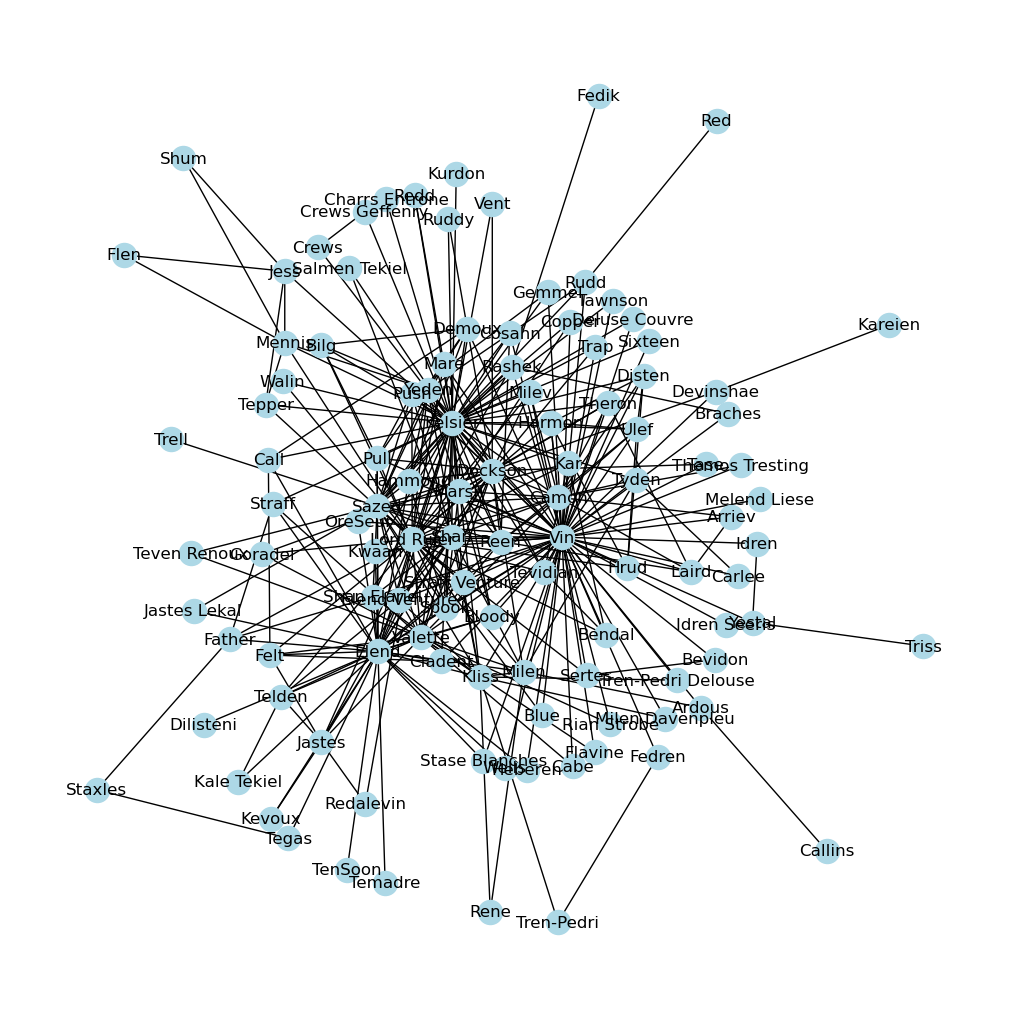

In [371]:
plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(Graph)
nx.draw(Graph, with_labels=True, node_color='lightblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

### Graph Visualization - Pyvis

In [374]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(Graph.degree)

nx.set_node_attributes(Graph, node_degree, 'size')

net.from_nx(Graph)
net.show("mistborn.html")

mistborn.html


# Centrality - Most important characters in Mistborn

In [376]:
#Degree centrality
degree_dict = nx.degree_centrality(Graph)
degree_dict

{'Kelsier': 0.5229357798165137,
 'Kurdon': 0.009174311926605505,
 'Lord Ruler': 0.3302752293577982,
 'Tepper': 0.03669724770642202,
 'Mennis': 0.06422018348623854,
 'Jess': 0.045871559633027525,
 'Shum': 0.01834862385321101,
 'Flen': 0.01834862385321101,
 'Reen': 0.11926605504587157,
 'Vin': 0.6330275229357798,
 'Ulef': 0.06422018348623854,
 'Camon': 0.1651376146788991,
 'Themos Tresting': 0.01834862385321101,
 'Theron': 0.05504587155963303,
 'Laird': 0.045871559633027525,
 'Dockson': 0.24770642201834864,
 'Trap': 0.027522935779816515,
 'Ruddy': 0.01834862385321101,
 'Yeden': 0.11926605504587157,
 'Marsh': 0.12844036697247707,
 'Arriev': 0.027522935779816515,
 'Milev': 0.045871559633027525,
 'Disten': 0.05504587155963303,
 'Harmon': 0.06422018348623854,
 'Hrud': 0.045871559633027525,
 'Push': 0.07339449541284404,
 'Mare': 0.05504587155963303,
 'OreSeur': 0.027522935779816515,
 'Vent': 0.01834862385321101,
 'Copper': 0.027522935779816515,
 'Gemmel': 0.027522935779816515,
 'Pull': 0.0825

<Axes: >

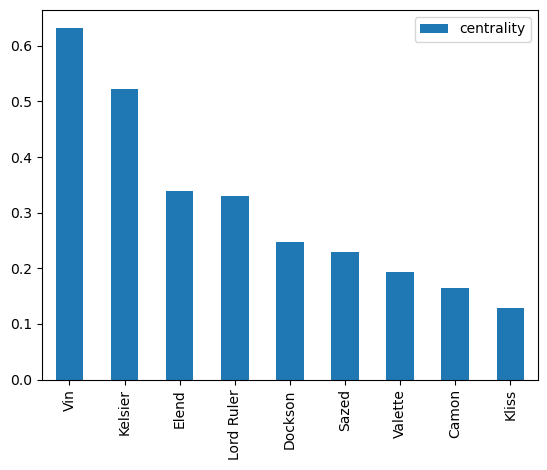

In [380]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

#plot top 10
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar')

<Axes: >

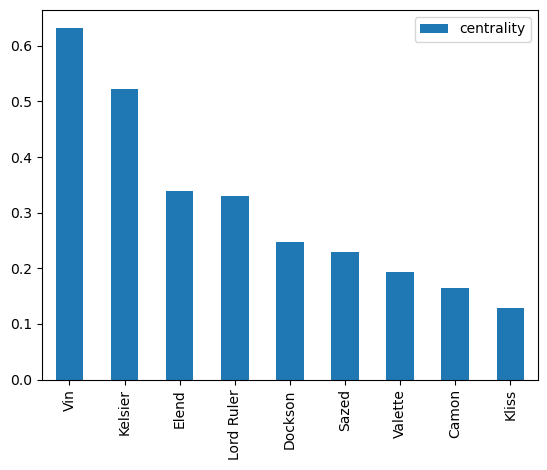

In [381]:
#Betweenness centrality
betweenness_dict = nx.betweenness_centrality(Graph)
betweenness_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar')

<Axes: >

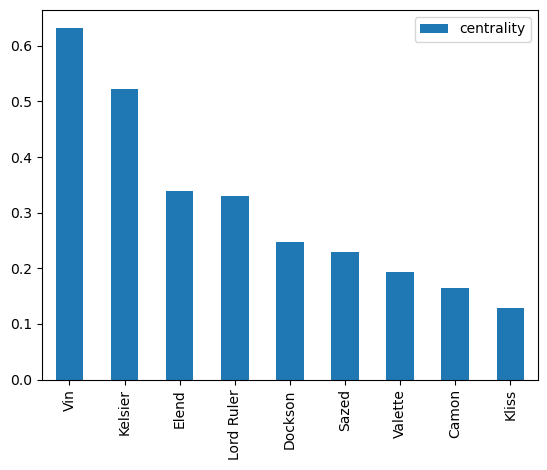

In [382]:
#Closeness centrality
closeness_dict = nx.closeness_centrality(Graph)
closeness_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar')

In [385]:
#Save centrality measures
nx.set_node_attributes(Graph, degree_dict, 'degree_centrality')
nx.set_node_attributes(Graph, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(Graph, closeness_dict, 'closeness_centrality')

In [391]:
nx.set_node_attributes(Graph, degree_dict, 'degree_centrality')

# Community Detection

In [392]:
import community as community_louvain

In [393]:
communities = community_louvain.best_partition(Graph)

In [394]:
communities

{'Kelsier': 0,
 'Kurdon': 0,
 'Lord Ruler': 1,
 'Tepper': 1,
 'Mennis': 1,
 'Jess': 1,
 'Shum': 1,
 'Flen': 1,
 'Reen': 0,
 'Vin': 4,
 'Ulef': 4,
 'Camon': 4,
 'Themos Tresting': 4,
 'Theron': 4,
 'Laird': 4,
 'Dockson': 0,
 'Trap': 0,
 'Ruddy': 0,
 'Yeden': 0,
 'Marsh': 0,
 'Arriev': 4,
 'Milev': 4,
 'Disten': 4,
 'Harmon': 4,
 'Hrud': 4,
 'Push': 0,
 'Mare': 0,
 'OreSeur': 2,
 'Vent': 0,
 'Copper': 0,
 'Gemmel': 0,
 'Pull': 0,
 'Cladent': 2,
 'Hammond': 0,
 'Straff Venture': 0,
 'Straff': 2,
 'Rashek': 4,
 'Sazed': 0,
 'Blue': 1,
 'Cosahn': 0,
 'Trell': 0,
 'Valette': 2,
 'Teven Renoux': 2,
 'Rudd': 4,
 'Red': 4,
 'Rian Strobe': 2,
 'Elend': 2,
 'Dilisteni': 2,
 'Elend Venture': 2,
 'Kwaan': 2,
 'Spook': 0,
 'Tawnson': 0,
 'Stase Blanches': 2,
 'Melend Liese': 4,
 'Shan Elariel': 3,
 'Shan': 3,
 'Heberen': 2,
 'Jastes Lekal': 2,
 'Charrs Entrone': 0,
 'Crews Geffenry': 0,
 'Crews': 0,
 'Salmen Tekiel': 3,
 'Deluse Couvre': 0,
 'Bloody': 2,
 'Flavine': 2,
 'Demoux': 0,
 'Bilg': 0,
 'C

In [395]:
nx.set_node_attributes(Graph, communities, 'group')

In [403]:
com_net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white')
com_net.show_buttons(filter_=['physics'])  # Allows tweaking physics settings
com_net.force_atlas_2based(gravity=-20)  # Adjust physics parameters

com_net.from_nx(Graph)
com_net.show("mistborn.html")

mistborn.html


## Character importance across books

In [14]:
# initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('data') if '.txt' in b.name]

#sort dir entries by name
all_books.sort(key=lambda x: x.name)
all_books

[<DirEntry '1_Mistborn_The-Final-Empire.txt'>,
 <DirEntry '2_Mistborn_The-Well-Of-Ascension.txt'>,
 <DirEntry '3_Mistborn_The-Hero-Of-Ages.txt'>]

In [15]:
from lib.utils.functions import *

In [16]:
character_df = character_df_init("Characters.txt")
ner = ner_and_patterns_init(character_df)

In [17]:
# loop through book list and create graphs
for book in all_books:
        
    book_text = open(book).read()
    
    #Get list of entities per sentence
    sent_entity_list = []

    for para in tqdm(book_text.split("\n\n")):
        para_doc = ner(para)
        sent_entity_list.extend(get_entity_list_per_sentence(para_doc))
      
    
    sent_entity_df = pd.DataFrame(sent_entity_list)
    
    #Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))
    
    #Filter out sentences without character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]

    #Create relationship df
    relationship_df = create_relationships(sent_entity_df_filtered, 5)
    
    #Create graph from a pandas dataframe
    Graph = nx.from_pandas_edgelist(relationship_df,
                                source = "source",
                                target = "target",
                                edge_attr = "value",
                                create_using = nx.Graph())
    
    books_graph.append(Graph)
                                    
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8009/8009 [01:07<00:00, 118.50it/s]


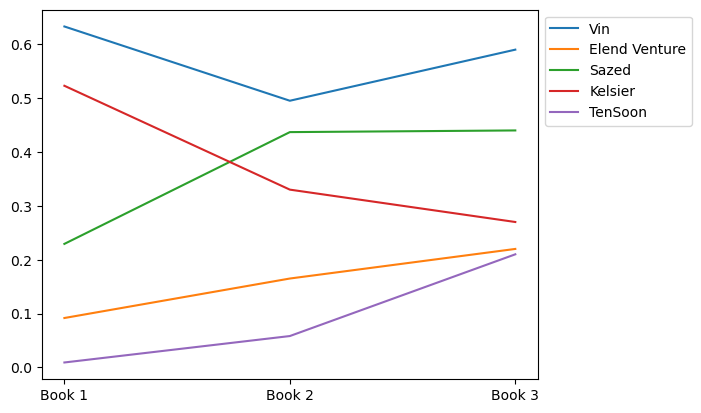

In [26]:
# creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

#creating a dataframe from list of degree centralities in all books
degree_evol_df = pd.DataFrame.from_records(evol)

#plotting degree centrality evolution of some main characters
graph = degree_evol_df[["Vin", "Elend Venture", "Sazed", "Kelsier", "TenSoon"]].plot()

graph.set_xticks([0, 1, 2])
graph.set_xticklabels(['Book 1', 'Book 2', 'Book 3'])
graph.legend(loc='upper left', bbox_to_anchor=(1, 1))